<a href="https://colab.research.google.com/github/3D-Lidar-FYP/Sensor_Fusion_FYP/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras==2.1.5

In [ ]:
%tensorflow_version 1.x 

In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/Colab\ Notebooks

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

Files in Drive:
'Copy of Welcome To Colaboratory'    train_points.npy
'Data Processing (bdb373c6).ipynb'   Untitled0.ipynb
'Data Processing.ipynb'		     Untitled10.ipynb
 Evaluation.ipynb		     Untitled1.ipynb
 intermediate_output.npy	     Untitled2.ipynb
 my_model_weights_450.h5	     Untitled3.ipynb
 processed_image.npy		     Untitled4.ipynb
 train_classes.npy		     Untitled5.ipynb
 trainHistoryDict_history450	     Untitled6.ipynb
 Training.ipynb			     Untitled8.ipynb
 train_labels.npy


Function to plot the bounding box on the image:

In [ ]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

def velocorners_to_imagecorners(point,calib_data):
    '''converts velo points to image points
    Based on the readme file for 3D object detection, x = P2 * R0_rect * Tr_velo_to_cam * y
    R0_rect contains a 3x3 matrix which you need to extend to a 4x4 matrix by adding a 1 as the bottom-right element 
    and 0's elsewhere.
    Tr_xxx is a 3x4 matrix (R|t), which you need to extend to a 4x4 matrix in the same way
    Remember, that calib data has to extracted for the relevant file instance
    
    Input: 
    point: 1 point in the velodyne coordinate, a list
    calib_data: calib file for that example
    
    Output:
    point in the 2D image coordinate as a 3 member list
    
    Scheme of i'''
    #appending the point with 1 for homogenization and making a numpy array
    point.append(1)
    point = np.array(point).reshape((4,1))
    
    R0_rect = calib_data["R0_rect"].reshape(3, 3)
    Tr_velo_to_cam = calib_data["Tr_velo_to_cam"].reshape(3, 4)
    P2 = calib_data["P2"].reshape(3, 4)
    
    R = np.zeros((4,4))
    R[:3,:3] = R0_rect
    R[3,3] = 1
    
    T = np.zeros((4,4))
    T[:3,:4] = Tr_velo_to_cam
    T[3,3] = 1
    
    point_image = np.dot(P2,np.dot(R,np.dot(T,point)))
    return list(np.squeeze(point_image.reshape(1,3)))
    
   
def draw_3D_boundingbox(box_corners, cl, calib_data, index, img_path, cl_prob):
    """Draws 3D bounding boxes
    Input:
    box_corners: a list of 8 box corners, each being a list with (x,y,z)
    cl: classification of object for that example, a string of Car, Van, or a Pedestrian
    calib_data: calib_data for that example
    index: example_index
    
    Output: plots figure along with saving it as BB_index.eps in the current directory
    """
    box_truth = labels[index]
    box_truth = np.squeeze(box_truth.reshape((1,8,3)))
    image = cv2.imread(img_path) #fill in the image path for this example 
    
    #order for finding points to line
    line_order = ([0, 1], [0, 3],[1, 5],[5, 7], [4, 7], [ 2,5], [6 ,7], [3, 6], [6, 1], [4, 3], [4 ,2], [0, 2])

    #color scheme for different objects
    type_c = { 'Car': (0, 0, 255), 'Van': (0, 255, 150), 'Pedestrian': (150,255,255) }
    
    type_c_gt = { 'Car': (255, 0, 0), 'Van': (255, 0, 0), 'Pedestrian': (255,0,0) }

    #have to feed 
    tracklet2d = []
    for i in box_corners:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d.append(point_image)
    tracklet2d = np.array(tracklet2d)
    
    tracklet2d_gt = []
    for i in box_truth:
        point_image = velocorners_to_imagecorners(list(i), calib_data)
        point_image = point_image/point_image[2]
        tracklet2d_gt.append(point_image)
    tracklet2d_gt = np.array(tracklet2d_gt)
    for k in line_order:    
        cv2.line(image, (int(tracklet2d[k[0]][0]), int(tracklet2d[k[0]][1])), (int(tracklet2d[k[1]][0]), int(tracklet2d[k[1]][1])), type_c[cl], 2)
        cv2.line(image, (int(tracklet2d_gt[k[0]][0]), int(tracklet2d_gt[k[0]][1])), (int(tracklet2d_gt[k[1]][0]), int(tracklet2d_gt[k[1]][1])), type_c_gt[cl], 2)
    
    iou = "{0:.2f}".format(IoU(box_corners, box_truth))
    cl_prob = "{0:.2f}".format(cl_prob)
    
   #making figure
    plt.subplots(1,1, figsize = (12,4))
    plt.title("Image with 3D bounding box; IOU = " + str(iou) +"  Class Probability = " + str(cl_prob) )
    plt.axis('off')
    plt.imshow(image)
    
    #fig.savefig('BB_'+str(index)+'.eps', format='eps', dpi=1200)
    
    

Function to calculate IOU:

In [ ]:
#Evaluation metric
# 3D IoU python Implementation
# [IoU](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)
from functools import reduce
def IoU(box0, box1):
  # box0: [x, y, z, d]
    l_a, b_a, h_a = abs(np.squeeze(box0[3:4] - box0[5:6]))
    l_b, b_b, h_b = abs(np.squeeze(box1[3:4] - box1[5:6]))
    d_a = np.array([l_a, b_a, h_a])
    d_b = np.array([l_b, b_b, h_b])
    
    box_a = [sum(box0[:][0])/8 , sum(box0[:][1])/8, sum(box0[:][2])/8]
    box_b = [sum(box1[:][0])/8 , sum(box1[:][1])/8, sum(box1[:][2])/8]
    
    r0 = d_a / 2
    
    s0 = np.squeeze(box_a - r0)
    e0 = np.squeeze(box_a + r0)
    r1 = d_b / 2
    s1 = np.squeeze(box_b - r1)
    e1 = np.squeeze(box_b + r1)
    overlap = [max(0,abs(min(e0[i], e1[i]) - max(s0[i], s1[i]))) for i in range(3)]
    intersection = reduce(lambda x,y:x*y, overlap)
    union = l_a*b_a*h_a + l_b*b_b*h_b - intersection
    return intersection / union

Load Data:

In [ ]:
points =  np.load('drive/Colab Notebooks/train_points.npy')
labels = np.load('drive/Colab Notebooks/train_labels.npy')
#labels = labels.reshape((7481,24))
labels = labels.reshape((5401,24))
classes = np.load('drive/Colab Notebooks/train_classes.npy')
classesNP = classes

In [ ]:

def read_calib_file(calib_path):
    """Read a calibration file."""
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if not line or line == "\n":
                continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data

Load Model:

In [ ]:
import numpy as np
import sys
import os
import tensorflow as tf
from keras import optimizers
from keras.layers import Input, Add, concatenate
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.layers import Dense, Flatten, Reshape, Dropout
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda
from keras.utils import np_utils
import h5py
from matplotlib.pyplot import imshow
import glob
import math
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K

from keras.models import load_model


Using TensorFlow backend.


In [ ]:
intermediate_output = np.load('drive/Colab Notebooks/intermediate_output.npy')
intermediate_output = np.squeeze(intermediate_output)
print(intermediate_output.shape)

(5402, 1000)


In [ ]:
def mat_mul(A, B):
    return tf.matmul(A, B)


# number of points in each sample
num_points = 2048

# number of categories
k = 3

# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

# ------------------------------------ Pointnet Architecture
# input_Transformation_net
input_points = Input(shape=(num_points, 3))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 3))(input_points)
#x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
#x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
#x = BatchNormalization()(x)
x = Dense(9, weights=[np.zeros([256, 9]), np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((3, 3))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
#g = BatchNormalization()(g)

# feature transform net
f = Convolution1D(64, 1, activation='relu')(g)
#f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
#f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
#f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
g = Convolution1D(64, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
#g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
#g = BatchNormalization()(g)

# global_feature
global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = Flatten()(global_feature)
# point_net_cls
#c = Dense(512, activation='relu')(global_feature)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(256, activation='relu')(c)
#c = BatchNormalization()(c)
#c = Dropout(rate=0.7)(c)
#c = Dense(k, activation='softmax')(c)
#prediction = Flatten()(c)
# --------------------------------------------------end of pointnet

#Fusion

resnet_activation = Input(shape=(intermediate_output.shape[1],), name='intermediate_output')
f = Concatenate()([global_feature, resnet_activation])

#Definition of MLP Layer
f = Dense(512, activation='relu')(f)
f = Dense(128, activation='relu')(f)
f = Dense(128, activation='relu')(f)
boxes = Dense(labels.shape[-1])(f)
classes = Dense(classes.shape[-1],activation='sigmoid')(f)


# print the model summary
model = Model(inputs=[input_points, resnet_activation], outputs=[boxes, classes])
model.load_weights('drive/Colab Notebooks/my_model_weights_450.h5')
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2048, 3)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 2048, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 2048, 64)     256         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 2048, 64)     4160        conv1d_4[0][0]                   
__________

In [ ]:
##index = 3100
index = 5369
test_point = points[index:index+1]
test_class = classesNP[index:index+1]
test_label = labels[index:index+1]
test_intermediate = intermediate_output[index:index+1]
box, classes = model.predict([test_point, test_intermediate])
##calib_path = "/Volumes/Hard Drive/data_object_calib/training/calib/003100.txt"
calib_path = "drive/Data For Fyp - Copy/training/calib/005369.txt"
test_calib = read_calib_file(calib_path)
img_path = "drive/Data For Fyp - Copy/training/images/005369.png"
box = np.squeeze(box.reshape((box.shape[0], 8,3)))
test_label = np.squeeze(test_label.reshape((test_label.shape[0], 8,3)))
print(box)
print(test_label)

[[ 6.9266877  -3.1721728  -1.502787  ]
 [ 7.118232   -3.653426   -1.4991422 ]
 [ 7.1621246  -3.0557435  -1.5067358 ]
 [ 6.8968225  -3.1721196   0.02709892]
 [ 7.1355867  -3.0788023   0.02413843]
 [ 7.2732925  -3.518923   -1.5005758 ]
 [ 7.0388494  -3.6271236   0.02756788]
 [ 7.2369757  -3.5532098   0.02208352]]
[[ 5.46462508e+00 -2.58031577e+00 -1.59014123e+00]
 [ 5.47621740e+00 -3.58024859e+00 -1.59014123e+00]
 [ 6.20457538e+00 -2.57173745e+00 -1.59014123e+00]
 [ 5.46462508e+00 -2.58031577e+00 -1.41194229e-04]
 [ 6.20457538e+00 -2.57173745e+00 -1.41194229e-04]
 [ 6.21616770e+00 -3.57167027e+00 -1.59014123e+00]
 [ 5.47621740e+00 -3.58024859e+00 -1.41194229e-04]
 [ 6.21616770e+00 -3.57167027e+00 -1.41194229e-04]]


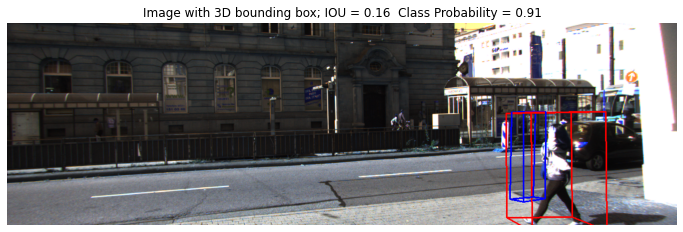

In [ ]:
#prediction
draw_3D_boundingbox(box, 'Car', test_calib, index, img_path, np.max(classes))


In [ ]:
print(classes)

[[1.7298774e-01 5.0972466e-04 9.0677094e-01]]


In [ ]:
#ground truth and IOU
#indices = np.load('permuted_indices.npy')
test_idx = range(5000,5401)
test_iou = []
for i in test_idx:
    test_point = points[i:i+1]
    test_intermediate = intermediate_output[i:i+1]
    box, classes = model.predict([test_point, test_intermediate])
    box = np.squeeze(box.reshape((box.shape[0], 8,3)))
    box_truth = labels[i]
    box_truth = np.squeeze(box_truth.reshape((1,8,3)))
    iou = IoU(box, box_truth)
    
    test_iou.append(iou)
    if(iou<0.5):
        print(i)
        print(iou)
avg_iou = sum(test_iou)/len(test_iou)
print(avg_iou)

5000
0.016202099645617016
5001
0.21552916456046325
5002
0.21236519885896565
5003
0.19322283957779923
5004
0.04024299028790246
5005
0.16249505678483545
5006
0.11643476548930484
5007
0.3504122525543781
5008
0.3593545039469661
5009
0.27065022115162224
5010
0.10645471537443395
5012
0.08235445386618079
5013
0.40708115816283497
5015
0.0007068090130894195
5016
0.05529058307619232
5017
0.07371492694449645
5018
0.16256106619687713
5019
0.03283650119702609
5020
0.00966191064492739
5021
0.35422339638877803
5022
0.044289804742014174
5023
0.10226816581343356
5024
0.05380946810693442
5025
0.3677455020435537
5026
0.0075813479693577135
5027
0.03637232384357648
5028
0.19404908214097313
5029
-13.906951141870117
5030
0.07939417406732703
5031
0.015411397297613918
5032
0.027215842177316714
5033
0.0020624792760190105
5034
0.05460730335608383
5035
0.012145277267038734
5036
0.07733404767424408
5037
0.05216274354233399
5038
0.09073999865775302
5039
0.007584387654527617
5040
0.019281730185454045
5043
0.26472089

Showing some test results:

In [ ]:
index = 4543
test_point = points[index:index+1]
test_class = classes[index:index+1]
test_label = labels[index:index+1]
test_intermediate = intermediate_output[index:index+1]
box, classes = model.predict([test_point, test_intermediate])
calib_path = "/Volumes/Hard Drive/data_object_calib/training/calib/004543.txt"
test_calib = read_calib_file(calib_path)
img_path = "/Volumes/Hard Drive/data_object_image_2/training/image_2/004543.png"
box = np.squeeze(box.reshape((box.shape[0], 8,3)))
#prediction
draw_3D_boundingbox(box, 'Pedestrian', test_calib, index, img_path, np.max(classes))

In [ ]:
index =4233
test_point = points[index:index+1]
test_class = classes[index:index+1]
test_label = labels[index:index+1]
test_intermediate = intermediate_output[index:index+1]
box, classes = model.predict([test_point, test_intermediate])
calib_path = "/Volumes/Hard Drive/data_object_calib/training/calib/004233.txt"
test_calib = read_calib_file(calib_path)
img_path = "/Volumes/Hard Drive/data_object_image_2/training/image_2/004233.png"
box = np.squeeze(box.reshape((box.shape[0], 8,3)))
#prediction
draw_3D_boundingbox(box, 'Car', test_calib, index, img_path, np.max(classes))